# Jul 9th, 2022 (Fig-6 mem plots -- draft)

**Motivation**: + Bar, Pie, etc <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
fig_dir = 'Fig6_Members'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig6_Members

## Prepare (512)

In [3]:
mice = Mice(nn)

kws_show = {
    'vmin': 0.1,
    'vmax': 1.0,
    'interp': 'none',
    'cmap': 'Spectral',
    'mask_thresh': 0.001,
    'contour_width': 0.2,
    'contour_alpha': 0.7,
    'contour_coarse': False,
    'add_disjoint': False,
    'add_title': True,
}

## Results

### K = 7; use prune

In [4]:
%%time

num_k = 7
results = member_results(
    mice=mice,
    num_k=num_k,
    use_prune=True,
    merge_thres=0.372,
    global_order=('infer', False),
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 11.7 s, sys: 3.23 s, total: 14.9 s
Wall time: 15 s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'mu_vals',
    'members',
    'reject',
    'scores'
]

In [5]:
from figures.fig_mem import mk_member_cmap
spect, accent = mk_member_cmap()

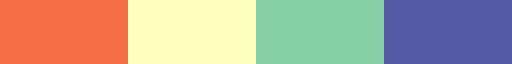

In [6]:
spect

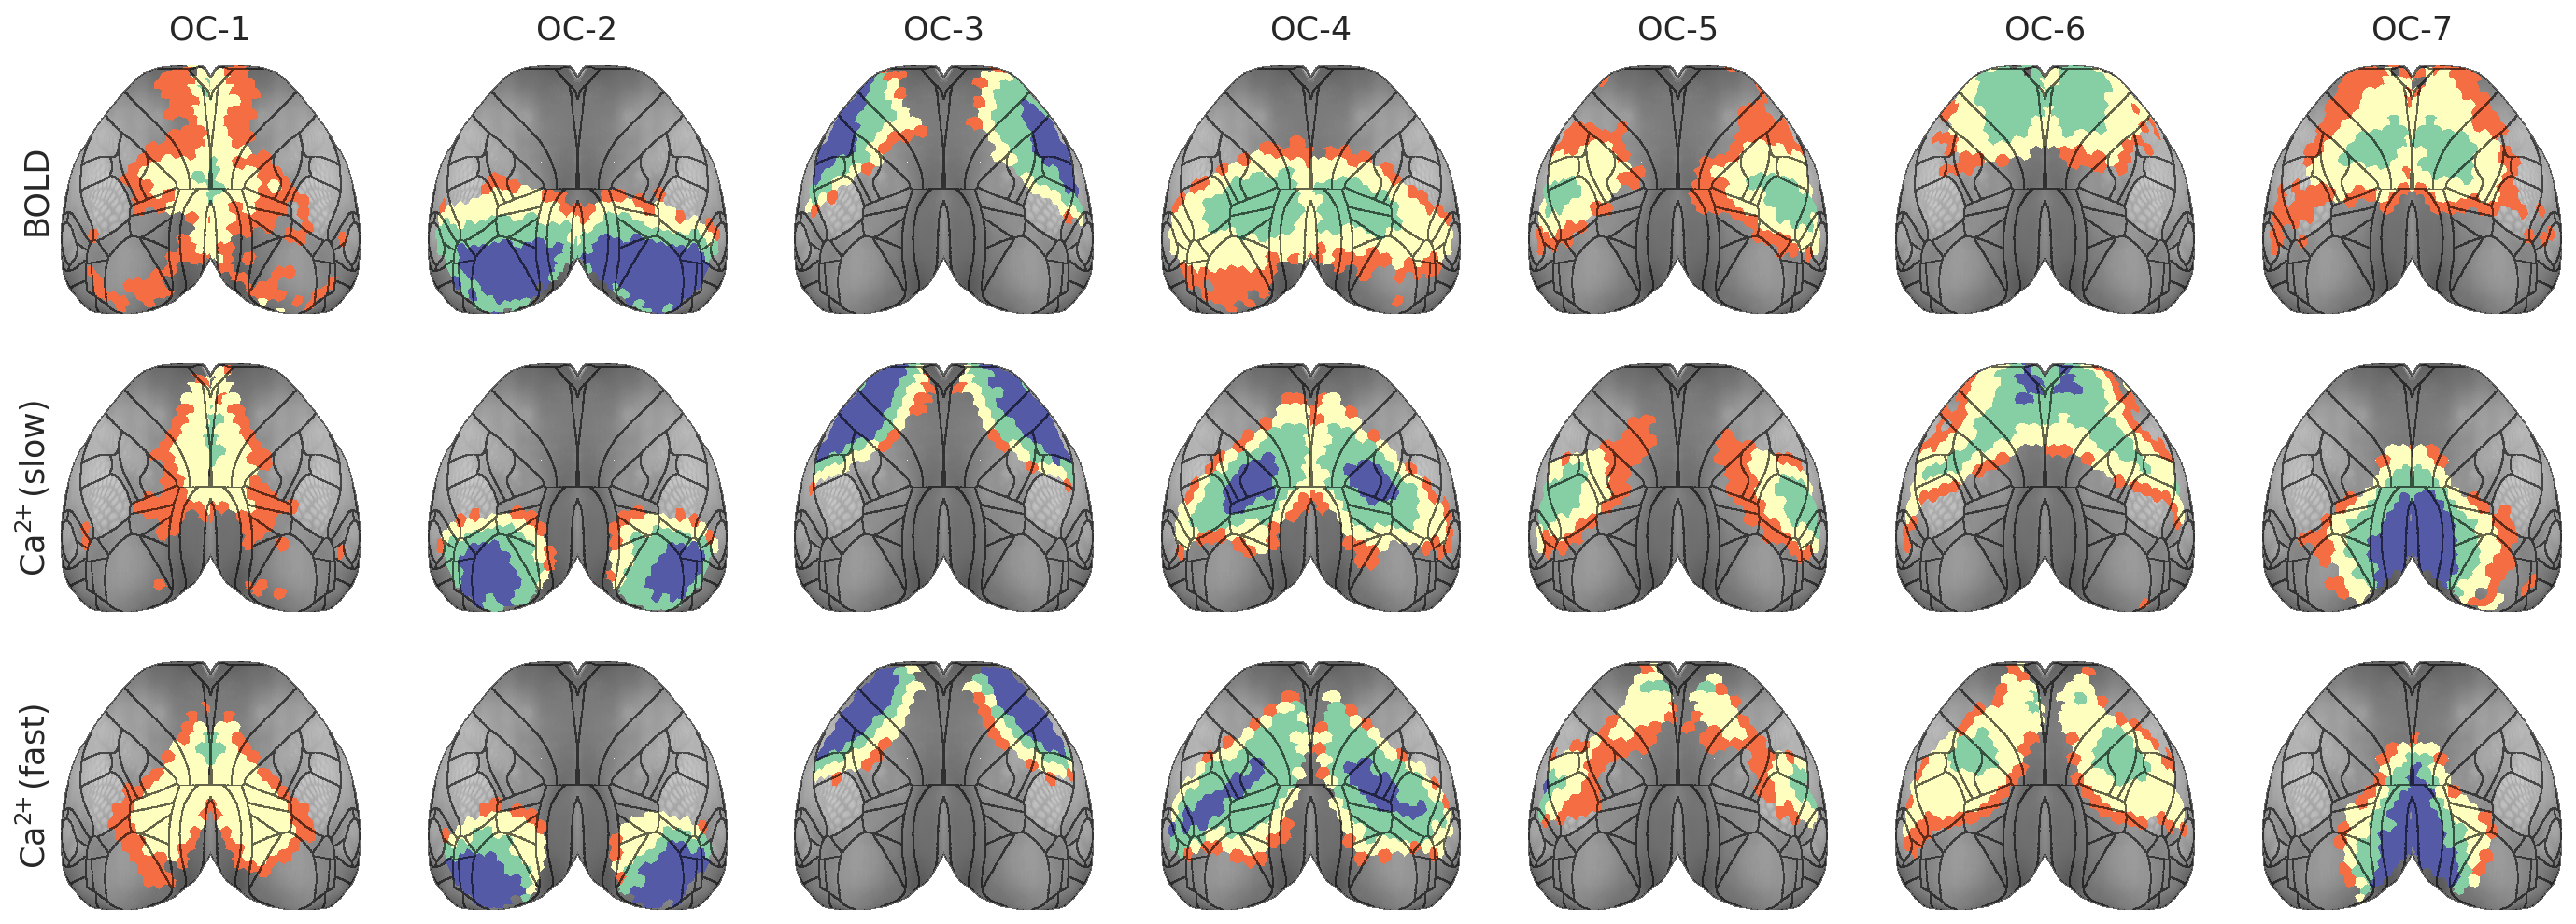

In [7]:
kws_show['cmap'] = spect
kws_show['vmin'] = 1
kws_show['vmax'] = len(results['mu_vals'])
kws_show['contour_cmap'] = 'Greys_r'
kws_show['contour_alpha'] = 0.6

_ = bt.show(results['members'], dpi=150, **kws_show)

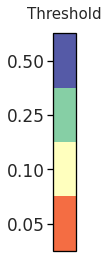

In [8]:
fig, cax, cbar = cbar_only(spect, vertical=True, tick_position='left')
cax.set_title('Threshold', fontsize=15, y=1.04, rotation=0)
cax.tick_params(labelsize=17)
cax.yaxis.set(
    ticks=[(i + 0.5) / len(results['mu_vals']) for i in range(len(results['mu_vals']))],
    ticklabels=[f"{mu:0.02f}" for mu in results['mu_vals']],
)
fig

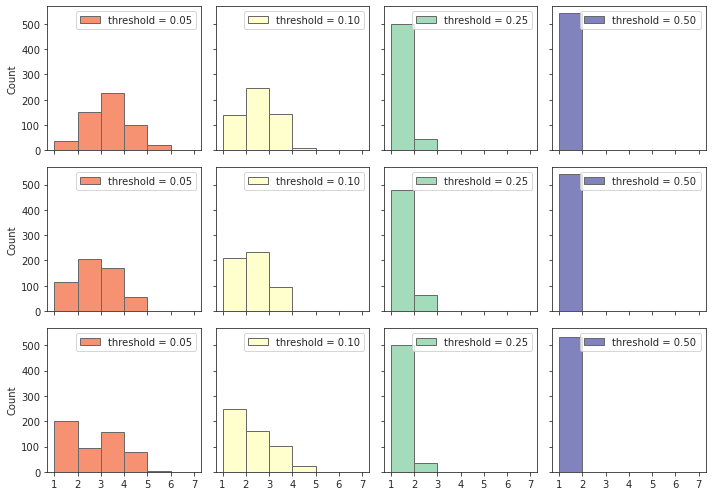

In [9]:
fig, axes = create_figure(3, 4, (10, 7), 'all', 'all')
for i, (mode, data) in enumerate(results['scores'].items()):
    for j, (mu, scores) in enumerate(data.items()):
        ax = axes[i, j]
        sns.histplot(
            data=scores['node_mem'],
            color=spect.colors[j],
            edgecolor='dimgrey',
            bins=np.linspace(1, num_k, num_k),
            label = f'threshold = {mu:0.2f}',
            ax=ax,
        )
        ax.legend(loc='upper right')
        ax.set_xticks(range(1, num_k + 1))

In [10]:
scores['oc_sizes'].sum(), 542 - scores['oc_sizes'].sum()

(534.0, 8.0)

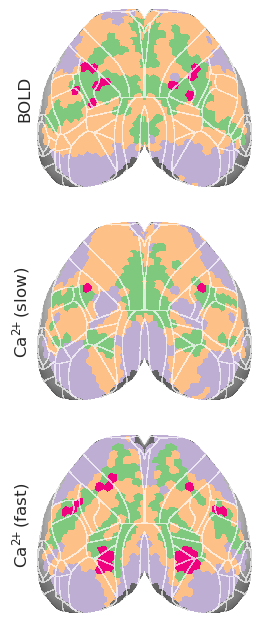

In [11]:
mu = 0.1

_ = bt.show(
    data={
        mode: d1[mu]['node_mem'] for
        mode, d1 in results['scores'].items()},
    vmin=1,
    vmax=4,
    cmap=accent,
    interp='none',
    mask_thresh=0.01,
    contour_coarse=False,
    contour_cmap='Greys',
    contour_alpha=0.7,
    figsize=(4.5, 8),
    dpi=100,
)

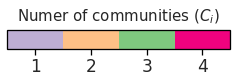

In [202]:
fig, cax, cbar = cbar_only(accent, vertical=False)
cax.set_title('Numer of communities ($C_i$)', y=1.2, fontsize=15)
cax.tick_params(labelsize=17)
cax.xaxis.set(
    ticks=[(i + 0.5) / 4 for i in range(4)],
    ticklabels=range(1, 4 + 1),
)
fig

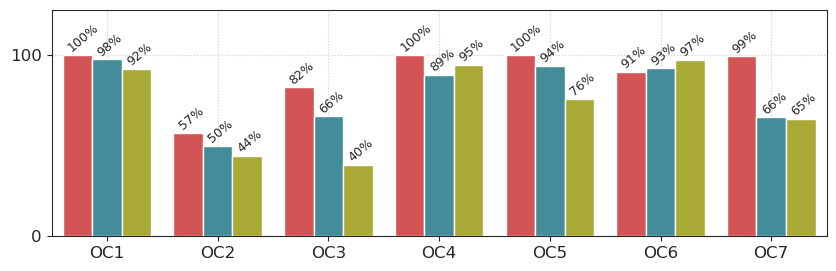

In [38]:
from figures.fig_mem import scores_bar
_ = scores_bar(results)

In [58]:
from figures.fighelper import prepare_palette

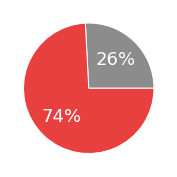

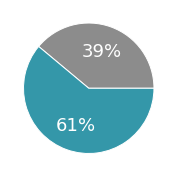

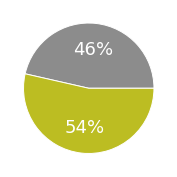

In [144]:
mu = 0.1
pal = prepare_palette()
grey = list(sns.color_palette('deep'))[-3]
# labels = ['Disjoint\n' + r'$C_i$ = 1', 'Mixed\n' + r'$C_i$ > 1']



for i, (mode, d1) in enumerate(results['scores'].items()):
    fig, ax = create_figure(1, 1, (3, 3), tight_layout=False, constrained_layout=False)
    
    ovp = d1[mu]['score_nodes']
    *_, autotexts = ax.pie(
        x=[1 - ovp, ovp],
        # labels=labels,
        startangle=0,
        autopct='%1.0f%%',
        colors=[grey, pal[mode]],
        textprops={'color': 'w', 'fontsize': 18},
    )
    # _ = [t.set_fontsize(20) for t in autotexts]
   #  _ = [t.set_color('white') for t in autotexts]
    plt.show()
    # ax.axis('equal')

In [189]:
figs, _ = scores_pie(results)

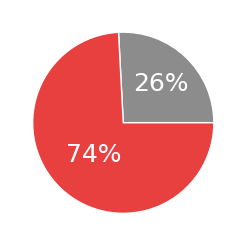

In [190]:
figs[0]

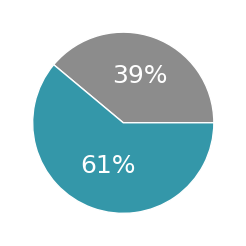

In [191]:
figs[1]

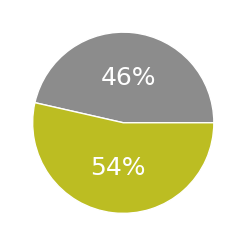

In [192]:
figs[2]

## Various k

In [16]:
%%time

results = {}
for num_k in [3, 7, 20]:
    if num_k == 7:
        global_order = ('infer', False)
        thres = 0.372
    else:
        global_order = 'infer'
        thres = None

    results[num_k] = member_results(
        mice=mice,
        num_k=num_k,
        use_prune=True,
        merge_thres=thres,
        global_order=global_order,
    )
# bt = BootStrap(**res['props_ca'])

CPU times: user 20.9 s, sys: 9.93 s, total: 30.8 s
Wall time: 30.9 s


In [17]:
dlist = []
for num_k, d1 in results.items():
    for mode, d2 in d1['scores'].items():
        for mu, d3 in d2.items():
            s = {
                'nodes': d3['score_nodes'],
                'OCs': np.nanmean(d3['score_ocs']),
                'OCs_weighted': d3['weighted_avg'],
            }
            dlist.append({
                'k': [num_k] * len(s),
                'mode': [mode] * len(s),
                'threshold': [mu] * len(s),
                'label': s.keys(),
                'score': s.values(),
            })
df = pd.DataFrame(merge_dicts(dlist))

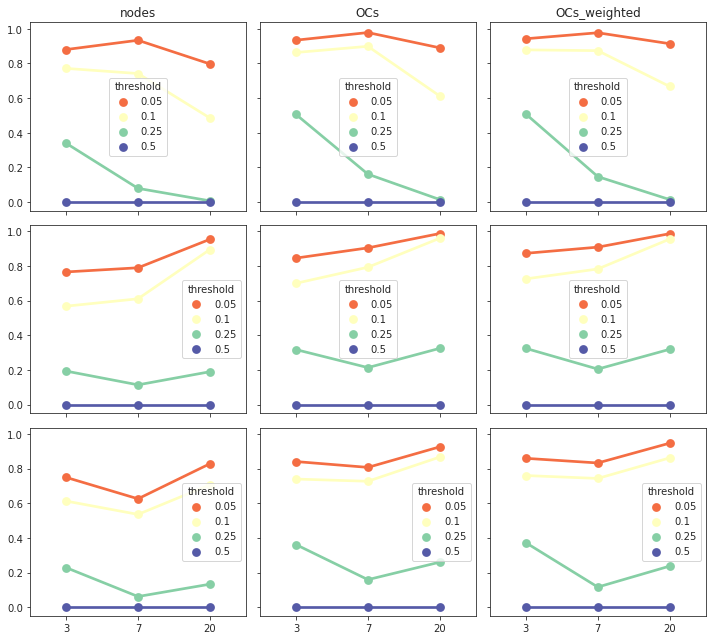

In [18]:
fig, axes = create_figure(3, 3, (10, 9), 'all', 'all')

for i, mode in enumerate(df['mode'].unique()):
    for j, lbl in enumerate(df['label'].unique()):
        ax=axes[i, j]
        _df = df.loc[
            (df['label'] == lbl) &
            (df['mode'] == mode)
        ]
        sns.pointplot(
            data=_df,
            x='k',
            y='score',
            hue='threshold',
            palette=dict(zip(results[num_k]['mu_vals'], colors)),
            ax=ax,
        )
        ax.set_xlabel('')
        ax.set_ylabel('')
        if i == 0:
            ax.set_title(lbl)

### K = 7; use raw

In [9]:
%%time

results = member_results(
    mice=mice,
    num_k=num_k,
    use_prune=False,
    merge_thres=0.372,
    global_order=('infer', False),
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 11min 15s, sys: 2min 16s, total: 13min 31s
Wall time: 13min 35s


['bt_dict', 'props_bo', 'props_ca', 'pi_sorted', 'mu_vals', 'members', 'reject']

In [10]:
results['mu_vals']

[0.05, 0.1, 0.25, 0.5]

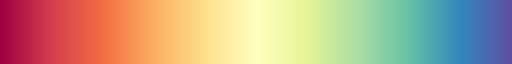

In [11]:
spect = sns.color_palette('Spectral', as_cmap=True)
spect

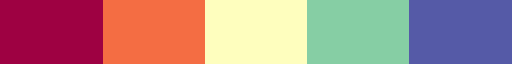

In [75]:
cmap = matplotlib.colors.ListedColormap(
    colors=[spect(i) for i in [0.0, 0.20, 0.5, 0.75, 0.98]],
    name='members',
)
cmap

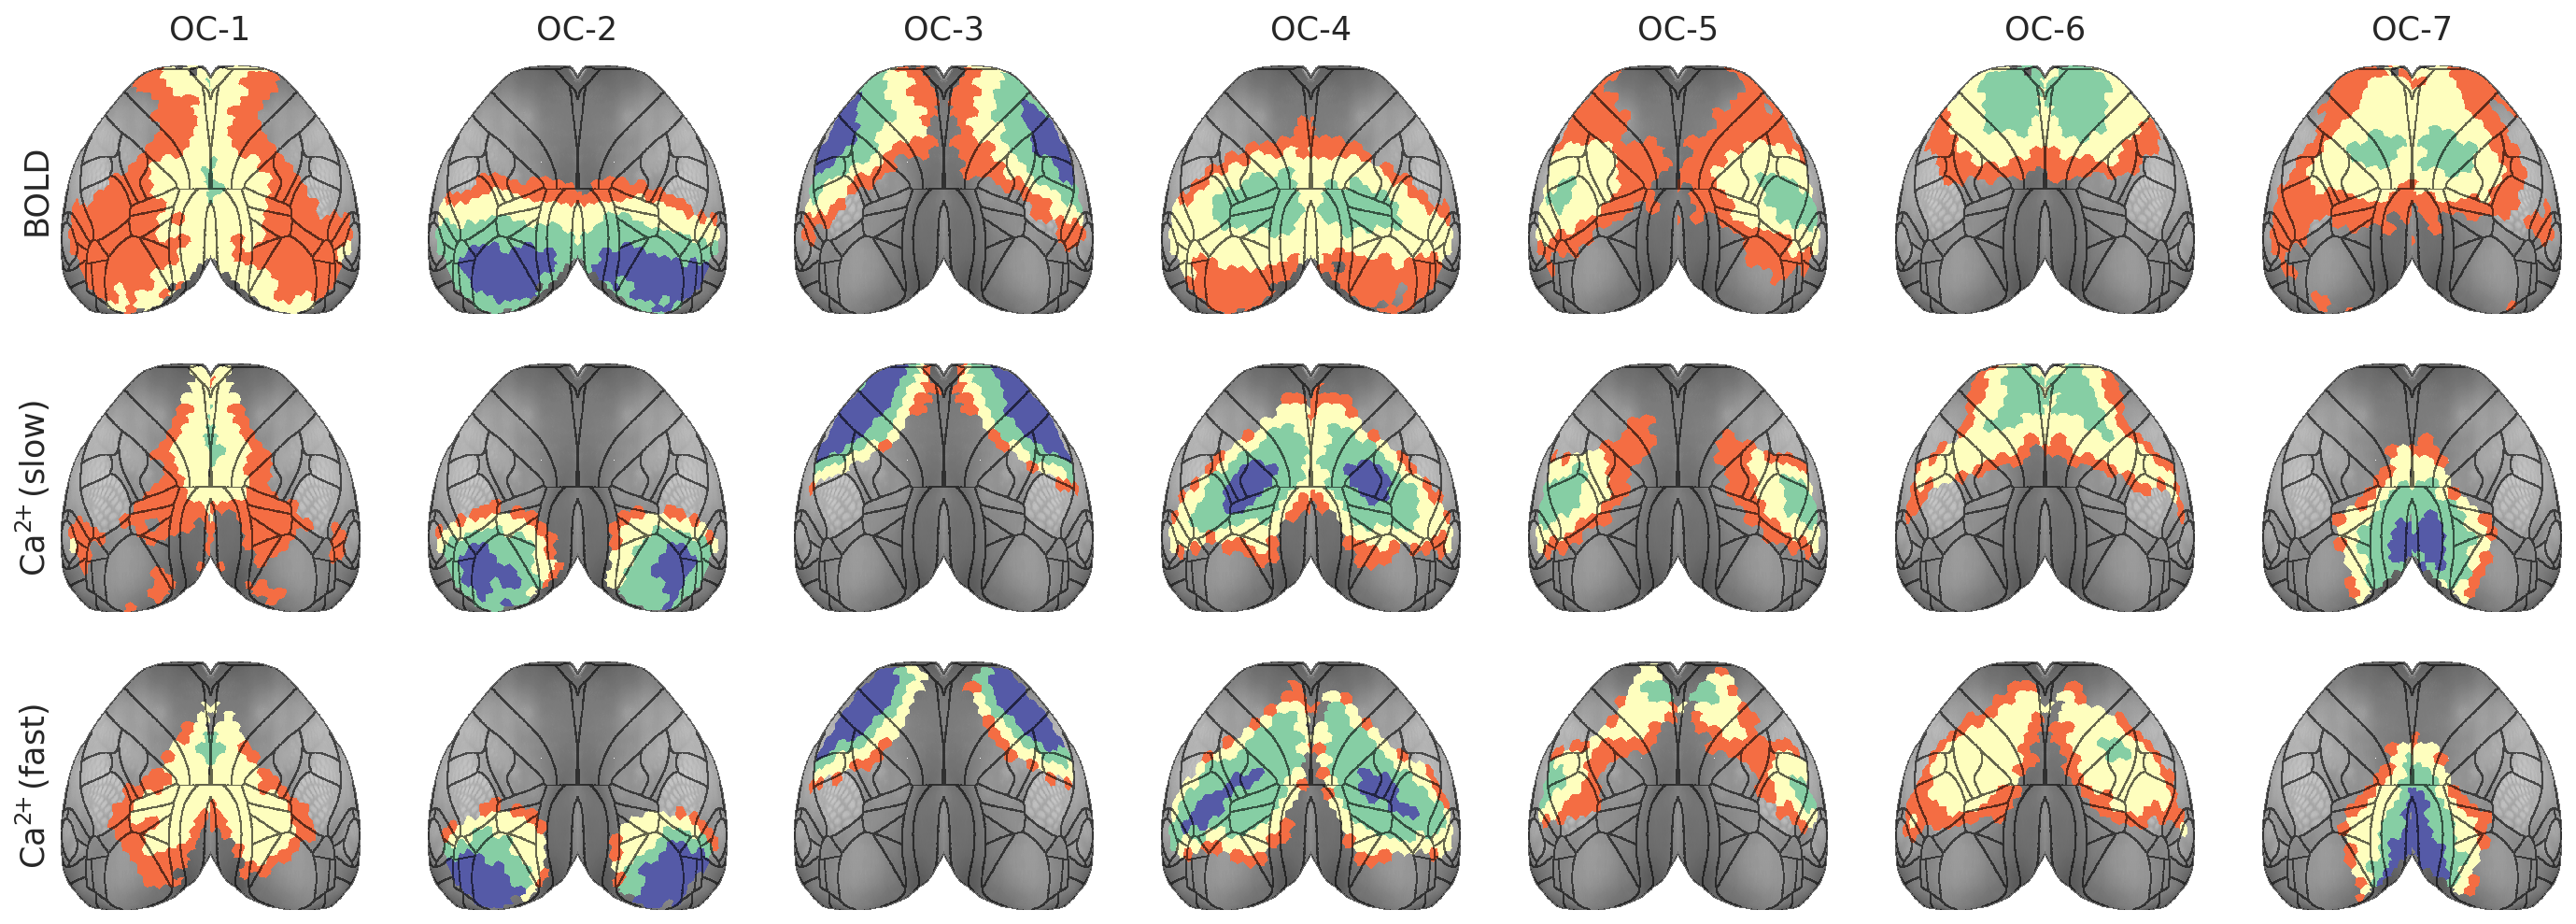

In [13]:
kws_show['cmap'] = cmap
kws_show['vmin'] = 1
kws_show['vmax'] = len(results['mu_vals'])
kws_show['contour_cmap'] = 'Greys_r'
kws_show['contour_alpha'] = 0.6
_ = bt.show(results['members'], dpi=150, **kws_show)

---
---

### continue from here

Decide:

- Prune vs. Raw?
- Which mu?
- Which gain?

---
---

In [55]:
for mu, rej in results['reject'][CAS].items():
    if mu == 0.1:
        break
    mu

In [56]:
rej.shape

(7, 542)

<matplotlib.image.AxesImage object at 0x7fce41bb0c70>

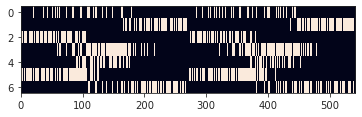

In [57]:
plt.imshow(rej, aspect=20)

In [58]:
mem = collections.Counter(rej.sum(0))
mem = {i: mem.get(i, 0) for i in range(num_k)}
mem[1] += mem[0]
mem.pop(0)

16

In [59]:
mem

{1: 211, 2: 235, 3: 94, 4: 2, 5: 0, 6: 0}

In [60]:
1 - mem[1] / sum(mem.values())

0.6107011070110702

In [61]:
ovp = rej.sum(0) > 1

In [62]:
rej[:, ovp].sum(1) / rej.sum(1)

array([1.        , 0.51470588, 0.67142857, 0.89010989, 0.93902439,
       0.95187166, 0.66891892])

In [65]:
(rej[:, ovp].sum(1) / rej.sum(1)).mean()

0.8051513301154621

In [66]:
c = 0
for a, b in zip(rej.sum(1), rej[:, ovp].sum(1) / rej.sum(1)):
    c += a * b
c = c / rej.sum()
c

0.7958115183246073

In [67]:
1 - c

0.20418848167539272

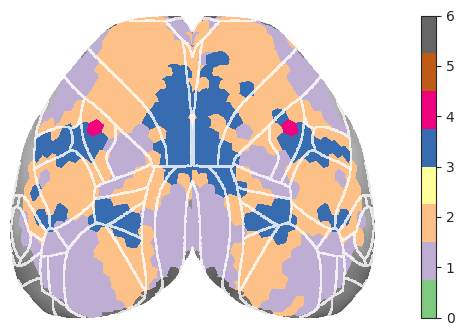

In [73]:
data = rej.sum(0)
data[data == 0] = np.nan

_ = bt.show(
    data,
    vmin=0,
    vmax=6,
    interp='tab10',
    mask_thresh=0.01,
    cmap='Accent',
    contour_coarse=False,
    cbar=True,
    figsize_x=20,
    figsize_y=20,
    dpi=100,
)

In [75]:
for mu, rej in results['reject'][CAF].items():
    if mu == 0.1:
        break
    mu

In [76]:
rej.shape

(7, 542)

<matplotlib.image.AxesImage object at 0x7fce417cbb80>

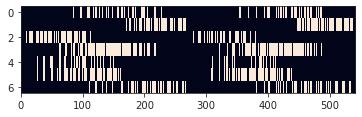

In [77]:
plt.imshow(rej, aspect=20)

In [78]:
mem = collections.Counter(rej.sum(0))
mem = {i: mem.get(i, 0) for i in range(num_k)}
mem[1] += mem[0]
mem.pop(0)

82

In [79]:
mem

{1: 256, 2: 162, 3: 103, 4: 21, 5: 0, 6: 0}

In [80]:
1 - mem[1] / sum(mem.values())

0.5276752767527675

In [81]:
ovp = rej.sum(0) > 1

In [82]:
rej[:, ovp].sum(1) / rej.sum(1)

array([0.98      , 0.47933884, 0.47321429, 0.955     , 0.98734177,
       0.99358974, 0.68292683])

In [83]:
(rej[:, ovp].sum(1) / rej.sum(1)).mean()

0.793058781957061

In [84]:
c = 0
for a, b in zip(rej.sum(1), rej[:, ovp].sum(1) / rej.sum(1)):
    c += a * b
c = c / rej.sum()
c

0.8047138047138047

In [85]:
1 - c

0.19528619528619529

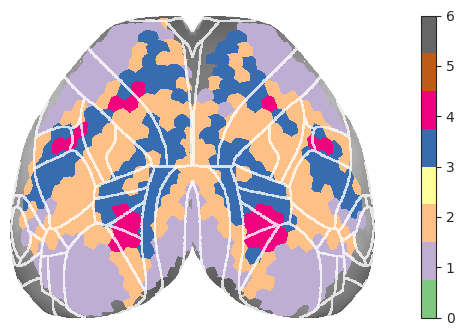

In [91]:
data = rej.sum(0)
data[data == 0] = np.nan

_ = bt.show(
    data,
    vmin=0,
    vmax=6,
    interp='none',
    mask_thresh=0.01,
    cmap='Accent',
    contour_coarse=False,
    cbar=True,
    figsize_x=20,
    figsize_y=20,
    dpi=100,
)

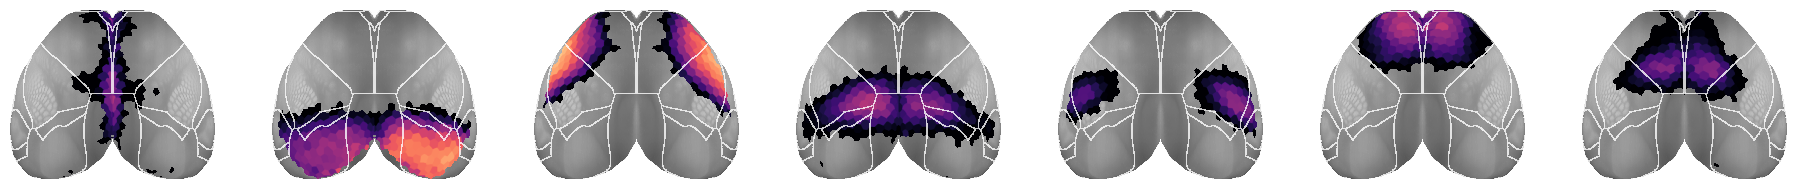

In [74]:
_ = bt.show(pi_B, vmin=0.2, vmax=0.9, mask_thresh=1/7)

In [75]:
ql = pi_B[1][o.l_ids]
ql = np.nanmean(ql[ql > 0.1])

qr = pi_B[1][o.r_ids]
qr = np.nanmean(qr[qr > 0.1])

qr / ql

1.3782181820939066

In [76]:
ql = pi_B[1][o.l_ids]
ql = np.nanmedian(ql[ql > 0.1])

qr = pi_B[1][o.r_ids]
qr = np.nanmedian(qr[qr > 0.1])

qr / ql

1.4183959412991425

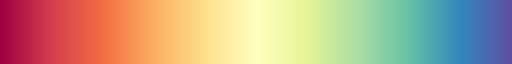

In [91]:
members = {}
for mode, o in results['bt_dict'].items():
    pi = avg(o.run_pi)
    x = np.zeros(pi.shape)
    se = o.get_booter(1000)(bn.nanmean(o.run_pi, -3))
    for mu in mu_vals:
        rej, _ = o.ttest(se, pi, mu)
        x[rej == 1] += 1
    x /= np.nanmax(x)
    members[mode] = x

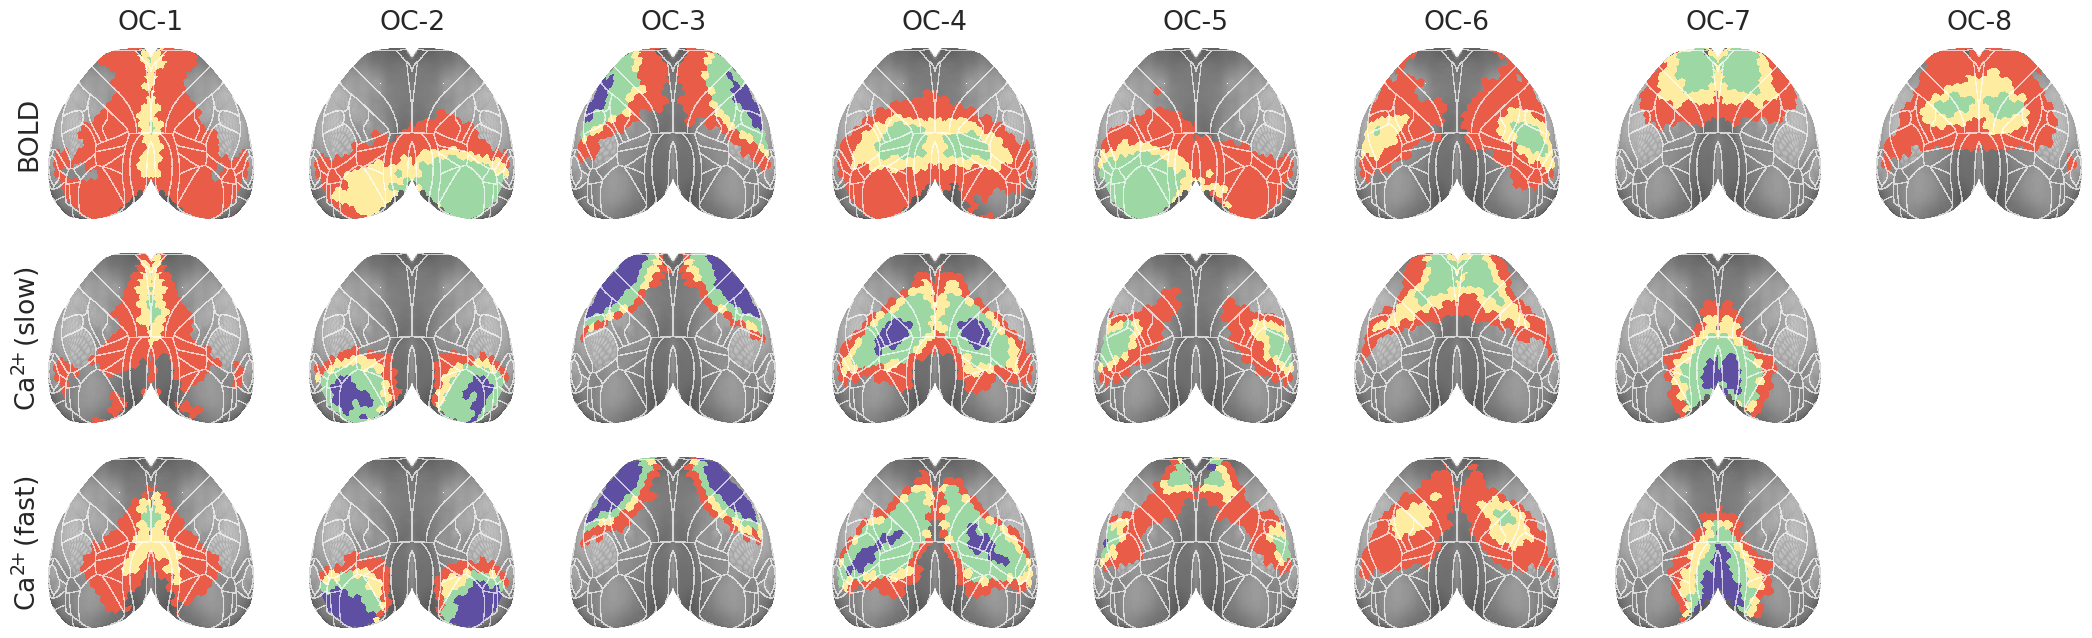

In [92]:
_ = bt.show(members, **kws_show)

In [69]:
x = members[BOLD].copy()

In [70]:
idx_1, idx_2 = 1, 4

In [71]:
x[idx_1][bt.l_ids] = x[idx_2][bt.r_ids]
x = x[np.delete(range(8), idx_2)]
x.shape

(7, 542)

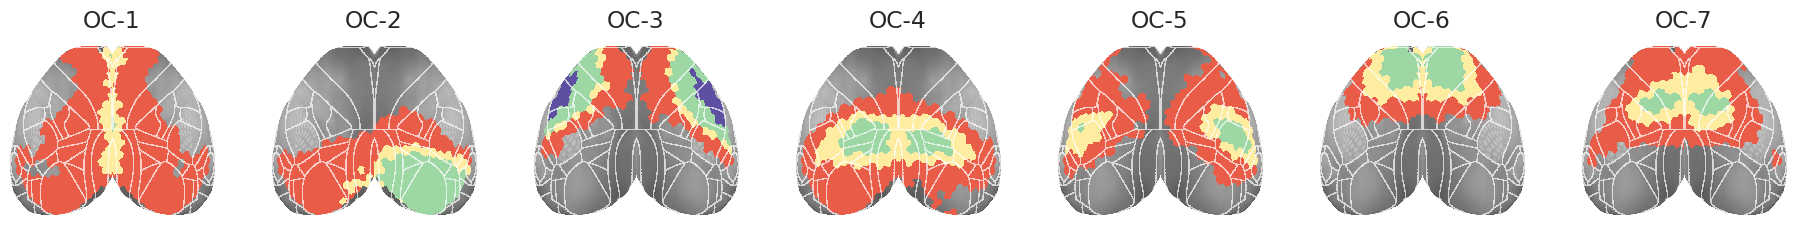

In [72]:
_ = bt.show(x, **kws_show)

### K = 20

In [73]:
%%time

results = proportion_results(
    mice=mice,
    num_k=20,
    # merge_thres=0.372,
    n_resamples=int(1e1),
    # global_order=('infer', False),
    bin_edges=(0.2, 1),
    n_cuts=4,
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 2min 44s, sys: 6.87 s, total: 2min 51s
Wall time: 3min 11s


['bt_dict', 'props_bo', 'props_ca', 'pi_sorted', 'df', 'bins']

In [77]:
df = results['df'].loc[
    (results['df']['x'] == .9) &
    (results['df']['subject'] == 'group')
]

<AxesSubplot:xlabel='oc_idx', ylabel='y'>

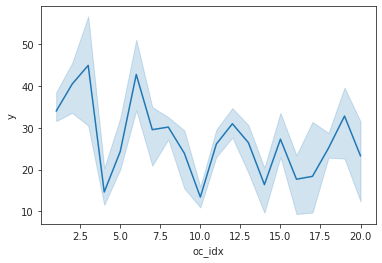

In [80]:
sns.lineplot(data=df, x='oc_idx', y='y')

In [81]:
mu_vals = [0.05, 0.15, 0.25, 0.5] 
mu_vals

[0.05, 0.15, 0.25, 0.5]

In [82]:
members = {}
for mode, o in results['bt_dict'].items():
    pi = avg(o.pi_prune)
    x = np.zeros(pi.shape)
    se, f = o.fit_boot(n_resamples=int(1e5))
    for mu in mu_vals:
        rej, _ = o.ttest(se, pi, mu)
        x[rej == 1] += 1
    x /= np.nanmax(x)
    members[mode] = x

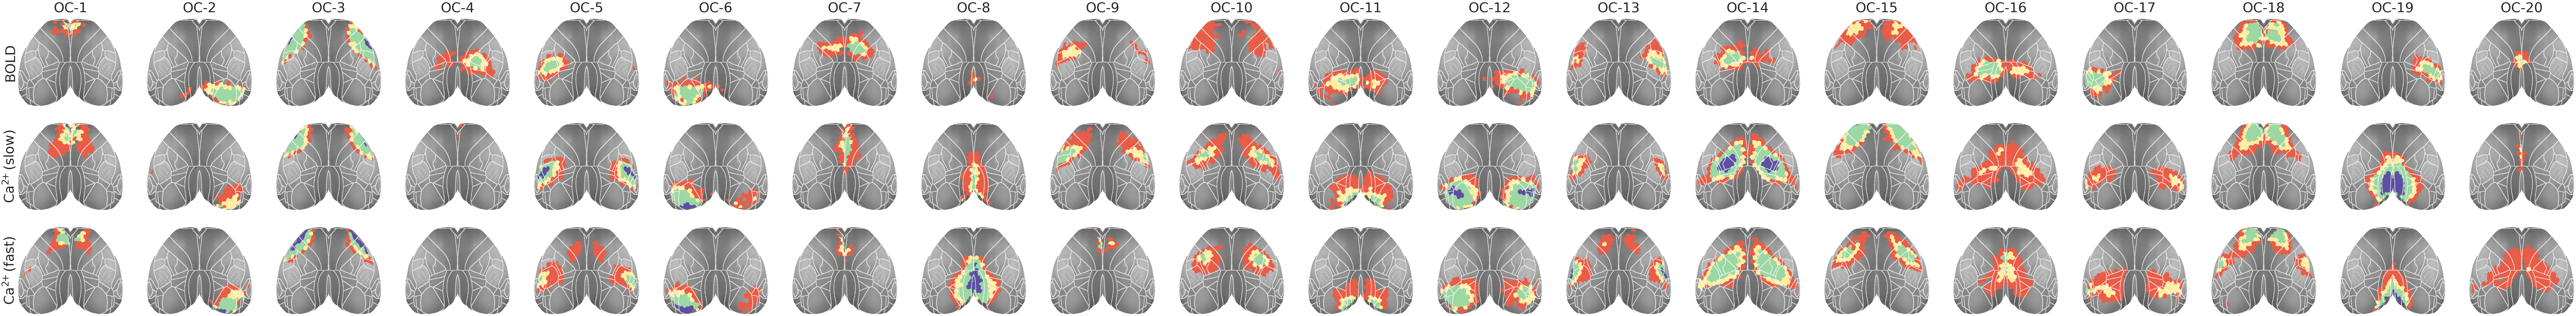

In [84]:
_ = bt.show(members, figsize_x=13.5, **kws_show)

In [85]:
members = {}
for mode, o in results['bt_dict'].items():
    pi = avg(o.run_pi)
    x = np.zeros(pi.shape)
    se = o.get_booter(1000)(bn.nanmean(o.run_pi, -3))
    for mu in mu_vals:
        rej, _ = o.ttest(se, pi, mu)
        x[rej == 1] += 1
    x /= np.nanmax(x)
    members[mode] = x

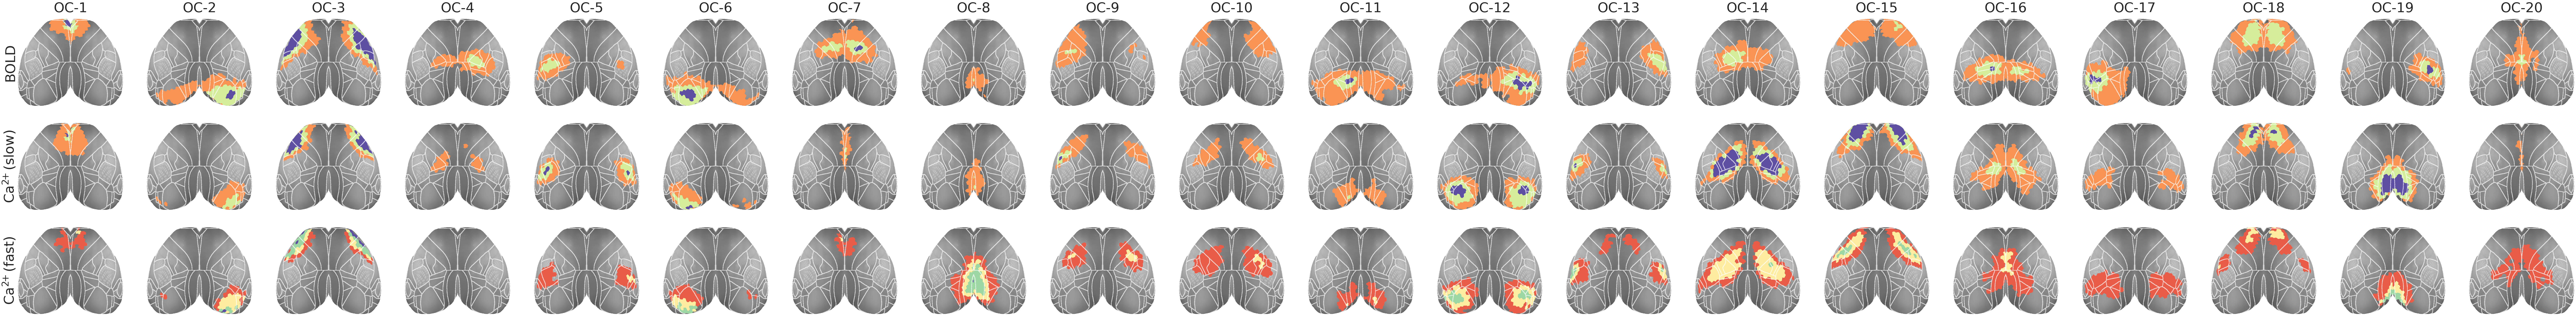

In [86]:
_ = bt.show(members, figsize_x=13.5, **kws_show)

## OCs

In [5]:
kws_show = {
    'vmin': 0.2,
    'vmax': 0.9,
    'mask_thresh': 1 / num_k,
    'add_disjoint': True,
    'add_title': True,
}

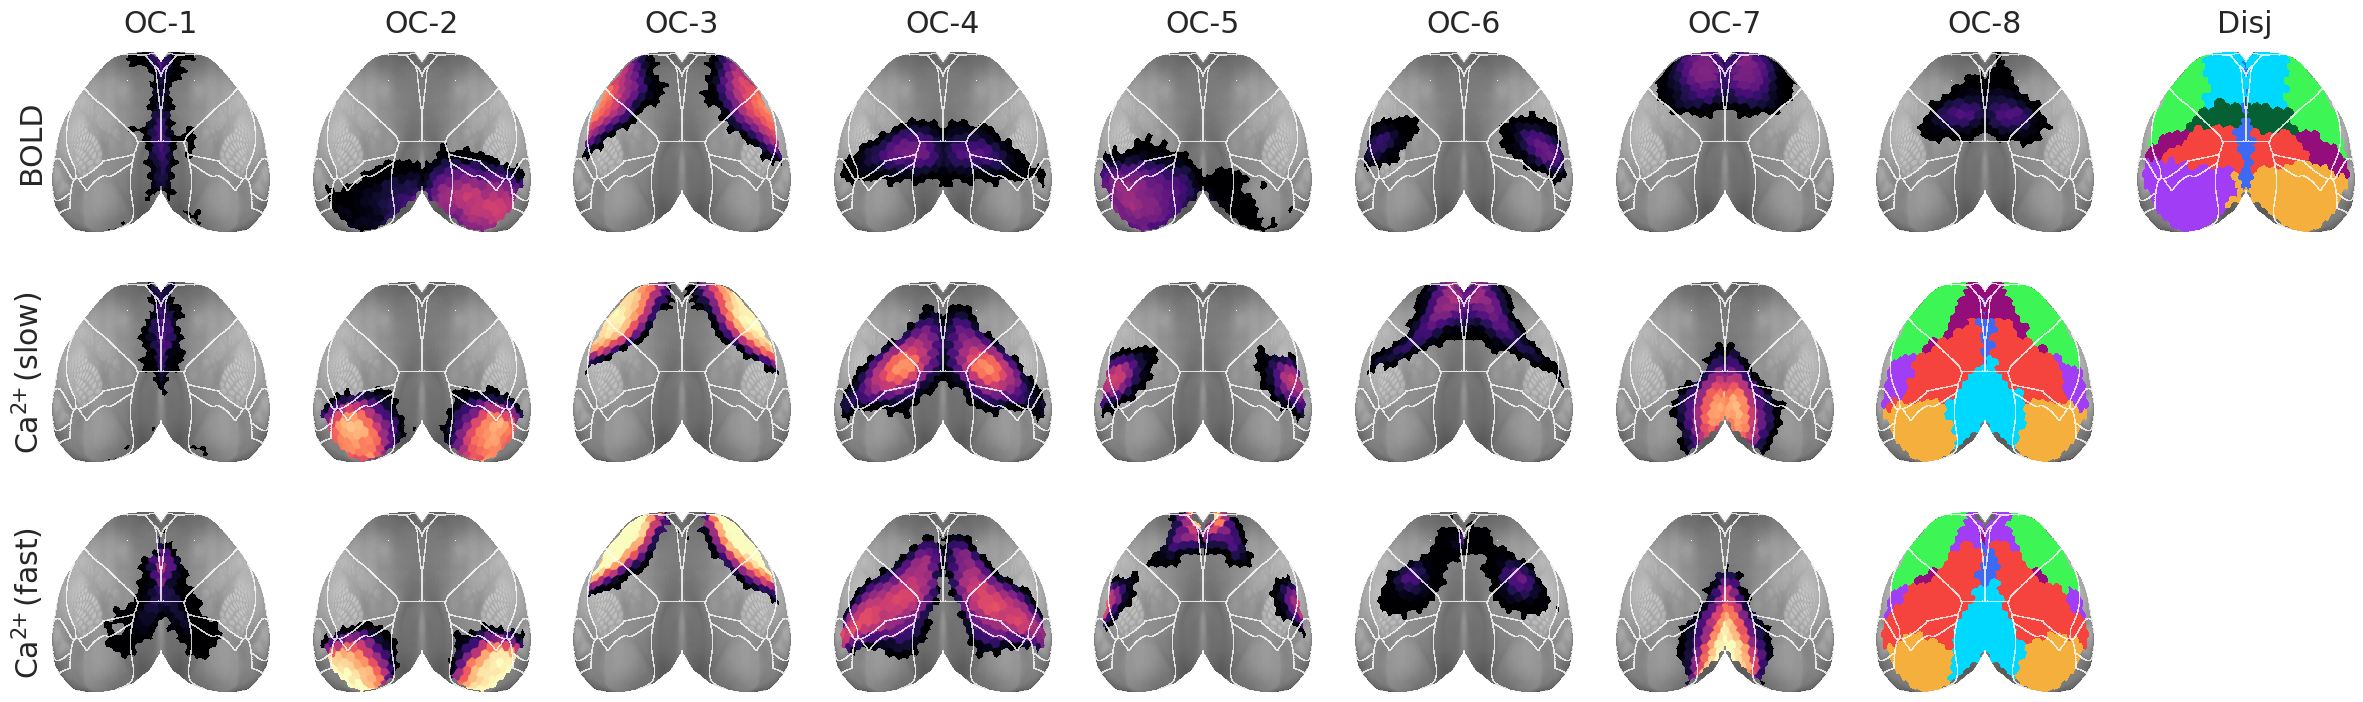

In [6]:
_ = bt.show(
    data={mode: avg(o.run_pi) for mode, o in results['bt_dict'].items()},
    **kws_show,
)

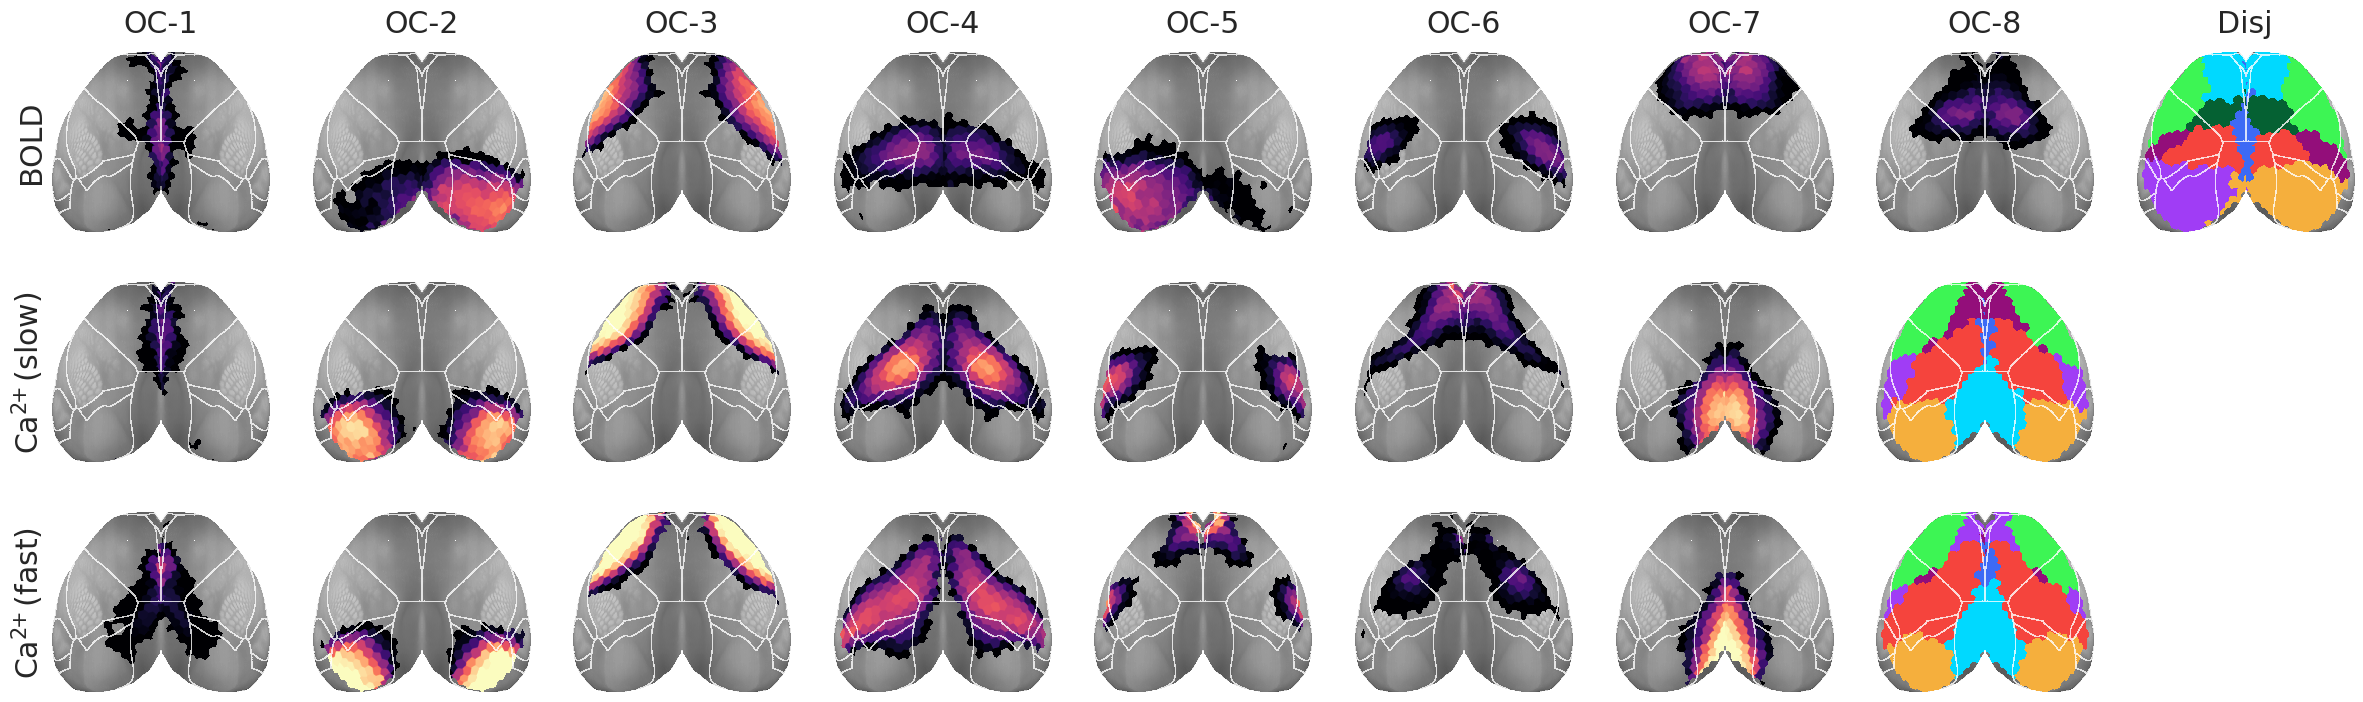

In [7]:
_ = bt.show(
    data={mode: avg(o.pi_prune) for mode, o in results['bt_dict'].items()},
    **kws_show,
)

## Propotion plot

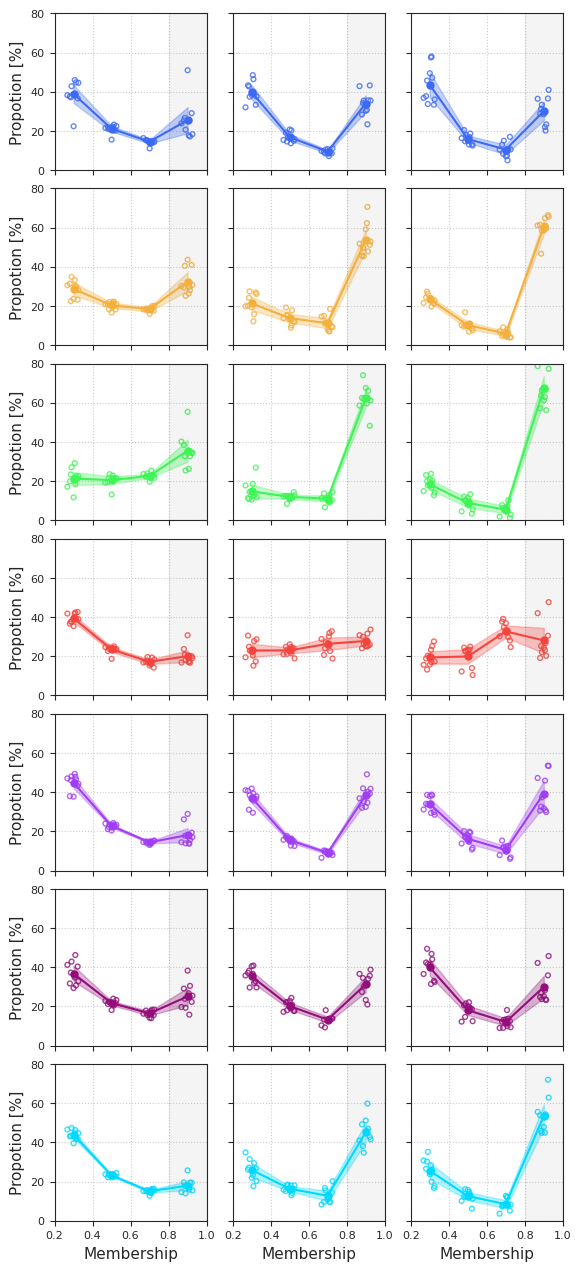

In [8]:
from figures.fig_prop import proportions_line as go
fig, _ = go(results['df'], results['bins'])

fig.savefig(pjoin(fig_dir, 'prop_ln.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'props_ln.png'), **kws_fig)

## Select good color

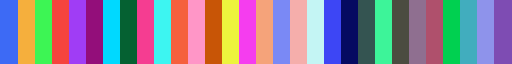

In [8]:
cmap = get_cluster_cmap(range(30))
cmap

In [18]:
partition = {mode: o.get_disjoint_community() for mode, o in bt_dict.items()}

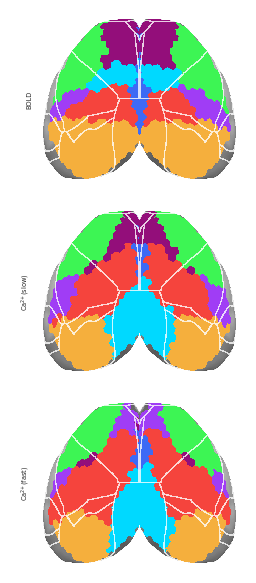

In [19]:
cmap = get_cluster_cmap(range(7))
_ = bt.show(
    data=partition,
    vmin=1,
    vmax=7,
    cmap=cmap,
    interp='none',
    figsize_x=4,
    figsize_y=6,
    dpi=200,
)

In [22]:
from figures.fighelper import prepare_palette
pal = prepare_palette()

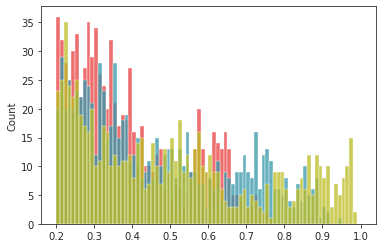

In [28]:
for mode, x in pi_sorted.items():
    sns.histplot(x[np.isfinite(x)], bins=np.linspace(0.2, 1, 81), color=pal[mode])

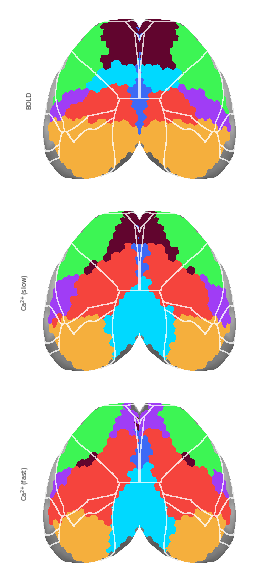